## Imports

In [1]:
import fastai
from fastai.vision.all import *
from hyperdash import monitor_cell, Experiment
import PIL

## Establishing CUDA device

In [2]:
# checking device number
assert torch.cuda.is_available()
index_device = torch.cuda.current_device()

## Read Data

In [3]:
data_path = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/"
# data_path = "/u/scratch/s/stecproj/image_data/image_based/hawaii/"

In [4]:
dls = ImageDataLoaders.from_folder(
    data_path, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=256, #512, changed to 256 since my(Hamlin) GPU ran out of memory
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

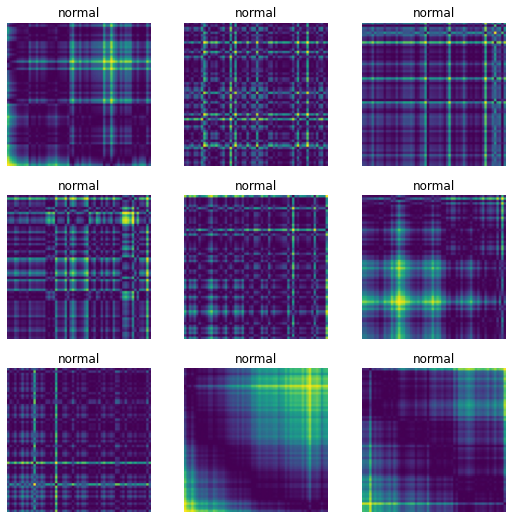

In [5]:
dls.show_batch()

In [6]:
dls.dataset

(#177416) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...]

In [7]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [18]:
# define the learner 
model = resnet34
learn = cnn_learner(
    dls, # data
    model, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

In [9]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

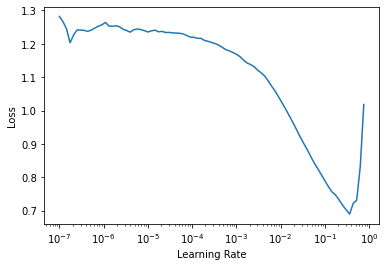

In [10]:
# find the minimum learning rate 
lr_min, lr_steep = learn.lr_find()

In [11]:
lr_min 

0.03630780577659607

In [12]:
lr = lr_min * 0.01
lr

0.0003630780577659607

In [13]:
# for now, manually set the learning rate 
lr = 0.00001

In [19]:
# parallel GPUs!
parallel_gpus = False
# if torch.cuda.device_count() > 1:
#     parallel_gpus = True
#     learn.model = nn.DataParallel(learn.model)

## Metric functions

In [20]:
def confusion_matrix_scores(cm: np.ndarray):
    """
    Returns a tuple of classification metrics according to
    the anomalous class as True Positive
    """
    accuracy = np.trace(cm)/np.sum(cm)
    total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
    pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
    precision = cm[0, 0] / total_anon
    recall = cm[0, 0] / pred_anon
    denom = (precision + recall) if (precision + recall) > 0 else 1
    F1 = 2 * precision * recall / denom
    return accuracy, precision, recall, F1

def calculating_coverage(predictions: torch.Tensor, targets: torch.Tensor, threhold: float):
    """
    Given a N-sized validation set,
    predictions is an N x 2 tensor since this is a binary classification problem
    targes is an N x 1 tensor where each targets[i] is the correct class
    
    returns 2 tuple of all coverages of each class
    """
    anomalous = np.where(targets == 0)
    normal = np.where(targets == 1)
    normal_predictions = predictions[normal, 1]
    anomalous_predictions = predictions[anomalous, 0]
    anom_coverage = np.average(anomalous_predictions > threshold)
    normal_coverage = np.average(normal_predictions > threshold)
    return anom_coverage, normal_coverage
    

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.885289,0.588771,0.291074,0.708926,07:53
1,0.698660,0.490053,0.093229,0.906771,07:53
2,0.575927,0.424658,0.036187,0.963813,07:53
3,0.465806,0.312139,0.017271,0.982729,07:52
4,0.307478,0.219839,0.010056,0.989944,07:53
5,0.180906,0.136726,0.006764,0.993236,07:53
6,0.127411,0.122270,0.007981,0.992019,07:53
7,0.086171,0.064760,0.005930,0.994070,07:54
8,0.052268,0.034257,0.005479,0.994521,07:52
9,0.037264,0.031489,0.004194,0.995806,07:53


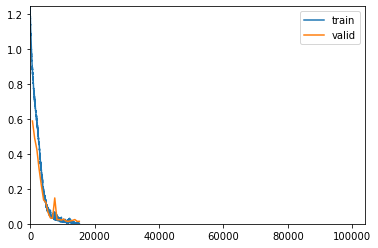

In [21]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# Create an experiment with a model name, then autostart
exp = Experiment("Tsunami-related sTEC d/dt Anomaly Detection")

# set the parameters 
model = exp.param("model", model)
lr = exp.param("learning_rate", lr)
device_name = exp.param("device_name", torch.cuda.get_device_name(index_device))
parallel_gpus = exp.param("parallel GPU", parallel_gpus)
threshold = exp.param("coverage confidence", 0.9)
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 


# train the model 
learn.fit(
    150, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.0001, 
            patience=3
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=5,
            min_delta=0.00001
        ),
        SaveModelCallback()
    ]
) 

# interpret results from test set
interp = ClassificationInterpretation.from_learner(learn) 
cm = interp.confusion_matrix()
# accuracy = np.trace(cm)/np.sum(cm)
# total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
# pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
# precision = cm[0, 0] / total_anon
# recall = cm[0, 0] / pred_anon
# denom = (precision + recall) if (precision + recall) > 0 else 1
# F1 = 2 * precision * recall / denom
results = confusion_matrix_scores(cm)
accuracy = exp.metric("accuracy", results[0])
precision = exp.metric("precision", results[1])
recall = exp.metric("recall", results[2])
F1_score = exp.metric("F1 Score", results[3])


# coverage calculation
predictions, targets = learn.get_preds() #by default uses validation set
anom_cov, normal_cov = calculating_coverage(predictions, targets, threshold)
anomaly_cov = exp.metric("anomaly coverage", anom_cov)
normal_cov = exp.metric("normal coverage", normal_cov)


# DONE: holdout recall, precision, accuracy, f-score,  as well 
# TODO: total training time 
# TODO: train loss, valid loss, error rate 

# end the experiment 
# TODO: in future move experiment end to include additional validation, experimentation 
exp.end()

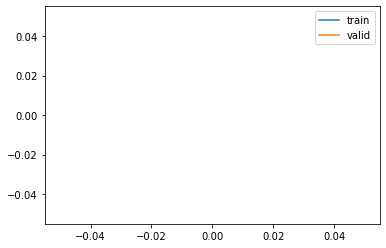

In [22]:
# plot the loss curve from model training
learn.recorder.plot_loss()

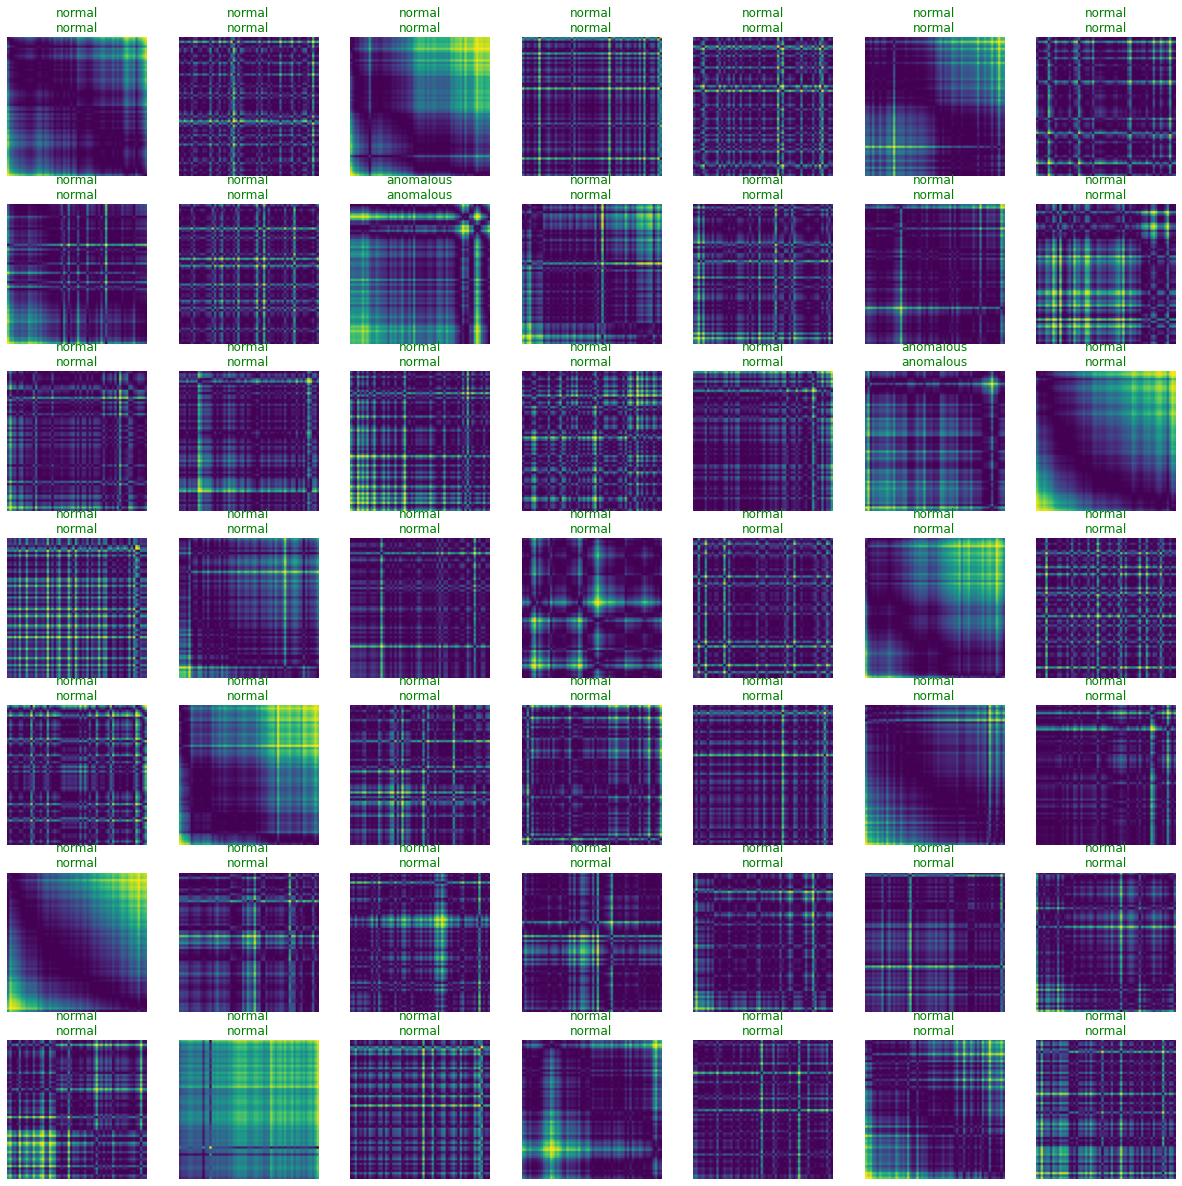

In [23]:
learn.show_results(max_n=49)

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

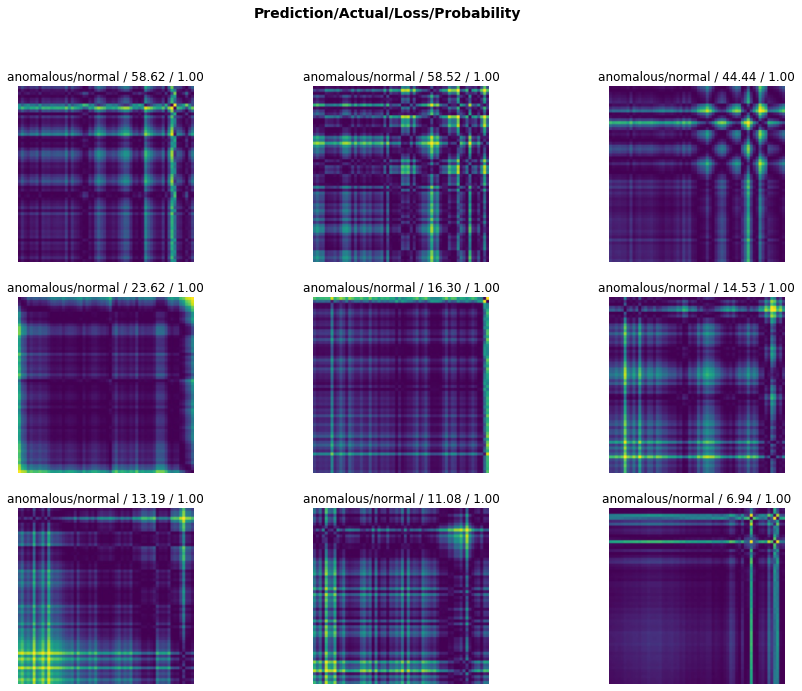

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

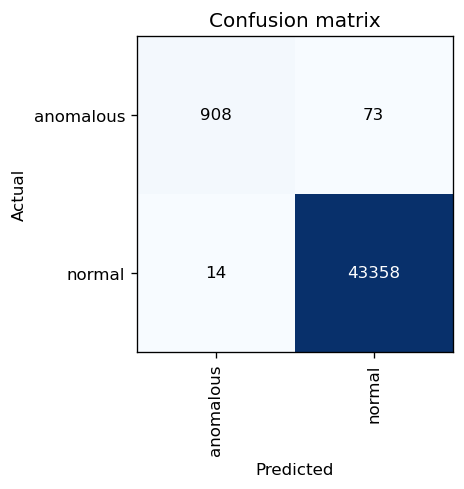

In [26]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [27]:
# TODO: from confusion matrix, generate anomalous and normal recall, precision, F-Scores. 

# SCRATCH work
### To be deleted when requesting merge

In [ ]:
# clear cache and variables 
a = learn.get_preds()


In [ ]:
np.unique(np.argmax(a[0], axis=1))


In [ ]:
learn.metrics[1].__dict__

In [ ]:
dl = learn.dls[1]

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
arr

In [ ]:
z = interp.confusion_matrix()

In [ ]:
np.trace(z)/np.sum(z)

In [ ]:
np.sum(z[:, 0])

In [ ]:
learn.dls.loaders[1]

In [ ]:
dl

In [ ]:
cm = interp.confusion_matrix()
accuracy = np.trace(cm)/np.sum(cm)
total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
precision = cm[0, 0] / total_anon
recall = cm[0, 0] / pred_anon
denom = (precision + recall) if (precision + recall) > 0 else 1
F1 = 2 * precision * recall / denom

In [ ]:
F1

In [ ]:
cm

In [ ]:
dl = learn.dls[0]


In [ ]:
vars(dl)

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
print(normal[4460])
len(normal)


In [ ]:
PIL.Image.open(anomalies[29])
PIL.Image.open(anomalies[29])
PIL.Image.open(normal[4460])

In [ ]:
anomalies = get_image_files(data_path + "pat2__G08/labeled/anomalous/")
normal = get_image_files(data_path + "pat2__G08/labeled/normal/")

In [ ]:
v, t = learn.get_preds()


In [ ]:
np.where(np.array(t) == 1)


In [ ]:
a

In [ ]:
predictions, targets = learn.get_preds()
anomalous = np.where(targets == 0)
normal = np.where(targets == 1)
normal_predictions = predictions[normal, 1]
anomalous_predictions = predictions[anomalous, 0]


In [ ]:
normal_predictions.shape

In [ ]:
np.average(normal_predictions > 0.9)

In [ ]:
type(predictions)

In [ ]:
a, b = calculating_coverage(predictions, targets, 0.9)

In [ ]:
a


In [ ]:
B

In [ ]:
b